# Network Attack Detection Model Training

This notebook implements multiple machine learning models to detect network attacks using our cybersecurity dataset. We'll train and compare the following models optimized for anomaly detection:

1. Random Forest Classifier
2. XGBoost Classifier  
3. LightGBM Classifier
4. Support Vector Machine (SVM)

We'll evaluate each model's performance using cybersecurity-specific metrics and save the best performing model for production use in our interactive dashboard.

In [7]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, 
                           precision_score, recall_score, f1_score, roc_auc_score,
                           roc_curve, auc)
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Create directories for models and results
os.makedirs('../models', exist_ok=True)
os.makedirs('../results', exist_ok=True)

# Load the cybersecurity dataset
print("Loading cybersecurity dataset...")
df = pd.read_csv('../Data/Train_data.csv')
print("Dataset loaded successfully!")
print(f"\nDataset shape: {df.shape}")
print(f"\nTarget distribution:")
print(df['class'].value_counts())
print(f"\nSample of the data:")
print(df.head())

Loading cybersecurity dataset...
Dataset loaded successfully!

Dataset shape: (25192, 42)

Target distribution:
class
normal     13449
anomaly    11743
Name: count, dtype: int64

Sample of the data:
   duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   
4         0           tcp      http   SF        199        420     0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0               0       0    0  ...                  25   
1               0       0    0  ...                   1   
2               0       0    0  ...                  26   
3               0       0    0  ...                 255   
4               0       0    0  ...                 255   

   dst_host_s

## Data Preprocessing for Cybersecurity Models
Let's prepare our network attack data for model training by:
1. Handling categorical and numerical features
2. Feature engineering for better attack detection
3. Splitting the data into training and testing sets
4. Scaling the features for optimal model performance
5. Preparing data for various ML algorithms

In [8]:
# Analyze and prepare the cybersecurity data
print("Analyzing data structure...")

# Identify categorical and numerical columns
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
numerical_columns = df.select_dtypes(include=[np.number]).columns.tolist()

# Remove target column from features
if 'class' in categorical_columns:
    categorical_columns.remove('class')
if 'class' in numerical_columns:
    numerical_columns.remove('class')

print(f"Categorical features ({len(categorical_columns)}): {categorical_columns}")
print(f"Numerical features ({len(numerical_columns)}): {len(numerical_columns)} columns")

# Prepare features and target
# Handle categorical variables with label encoding
df_processed = df.copy()
label_encoders = {}

# Encode categorical variables and keep track of encoders
for col in categorical_columns:
    if col != 'class':
        le = LabelEncoder()
        df_processed[col] = le.fit_transform(df_processed[col].astype(str))
        label_encoders[col] = le
        print(f"Encoded {col}: {len(le.classes_)} unique values")

# Prepare feature matrix and target vector
feature_columns = categorical_columns + numerical_columns
X = df_processed[feature_columns]
y = df_processed['class']

print(f"\nFeature matrix shape: {X.shape}")
print(f"Feature columns ({len(feature_columns)}): {feature_columns}")

# Encode target variable for consistency
target_encoder = LabelEncoder()
y_encoded = target_encoder.fit_transform(y)

print(f"\nTarget classes: {target_encoder.classes_}")
print(f"Target distribution:")
for i, class_name in enumerate(target_encoder.classes_):
    count = (y_encoded == i).sum()
    print(f"  {class_name}: {count} ({count/len(y_encoded)*100:.1f}%)")

# Split the data with stratification for balanced sampling
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_encoded
)

# Scale the features for models that need it
scaler = StandardScaler()
# Only scale numerical features to preserve categorical feature names
scaler.fit(X_train[numerical_columns])

# Create scaled versions for models that need scaling
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

if numerical_columns:
    X_train_scaled[numerical_columns] = scaler.transform(X_train[numerical_columns])
    X_test_scaled[numerical_columns] = scaler.transform(X_test[numerical_columns])

print(f"\nData preprocessing completed!")
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

# Save comprehensive preprocessing objects
preprocessing_objects = {
    'scaler': scaler,
    'target_encoder': target_encoder,
    'label_encoders': label_encoders,
    'feature_columns': feature_columns,
    'categorical_columns': categorical_columns,
    'numerical_columns': numerical_columns,
    'original_data_sample': df.head(3).to_dict(),  # For reference
    'encoding_info': {col: list(label_encoders[col].classes_) for col in label_encoders.keys()}
}

with open('../models/preprocessing_objects.pkl', 'wb') as f:
    pickle.dump(preprocessing_objects, f)

print(f"Preprocessing objects saved to '../models/preprocessing_objects.pkl'")

# Display detailed feature statistics
print(f"\nDetailed Feature Analysis:")
feature_stats = pd.DataFrame({
    'Feature': feature_columns,
    'Type': ['Categorical' if col in categorical_columns else 'Numerical' for col in feature_columns],
    'Unique_Values': [X[col].nunique() for col in feature_columns],
    'Missing_Values': [X[col].isnull().sum() for col in feature_columns],
    'Data_Range': [f"[{X[col].min():.2f}, {X[col].max():.2f}]" if col in numerical_columns 
                   else f"[{X[col].min()}, {X[col].max()}]" for col in feature_columns]
})

print("\nFirst 15 features:")
print(feature_stats.head(15))

# Verify data integrity
print(f"\nData Integrity Check:")
print(f"✓ No missing values in features: {X.isnull().sum().sum() == 0}")
print(f"✓ All categorical features encoded: {all(X[col].dtype in ['int64', 'float64'] for col in categorical_columns)}")
print(f"✓ Feature names preserved: {list(X.columns) == feature_columns}")
print(f"✓ Target distribution balanced: {(y_encoded == 0).sum()} normal, {(y_encoded == 1).sum()} anomaly")

Analyzing data structure...
Categorical features (3): ['protocol_type', 'service', 'flag']
Numerical features (38): 38 columns
Encoded protocol_type: 3 unique values
Encoded service: 66 unique values
Encoded flag: 11 unique values

Feature matrix shape: (25192, 41)
Feature columns (41): ['protocol_type', 'service', 'flag', 'duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_s

## Model Training and Evaluation
Let's train and evaluate multiple machine learning models optimized for network attack detection:
1. Random Forest - Ensemble method with feature importance
2. XGBoost - Gradient boosting for high performance
3. LightGBM - Fast gradient boosting
4. Support Vector Machine - Effective for high-dimensional data

For each model, we'll:
- Train with optimized hyperparameters
- Perform cross-validation
- Generate predictions on test set
- Calculate cybersecurity-specific metrics (Precision, Recall, F1-Score)
- Create detailed visualizations

Starting model training and evaluation...
Training on 20153 samples, Testing on 5039 samples
Number of features: 41
Classes: ['anomaly' 'normal']

 Training Random Forest model...



RANDOM FOREST EVALUATION RESULTS
Accuracy:  0.9974
Precision: 0.9974
Recall:    0.9974
F1-Score:  0.9974
ROC AUC:   1.0000

Detailed Classification Report:
              precision    recall  f1-score   support

     anomaly       1.00      1.00      1.00      2349
      normal       1.00      1.00      1.00      2690

    accuracy                           1.00      5039
   macro avg       1.00      1.00      1.00      5039
weighted avg       1.00      1.00      1.00      5039



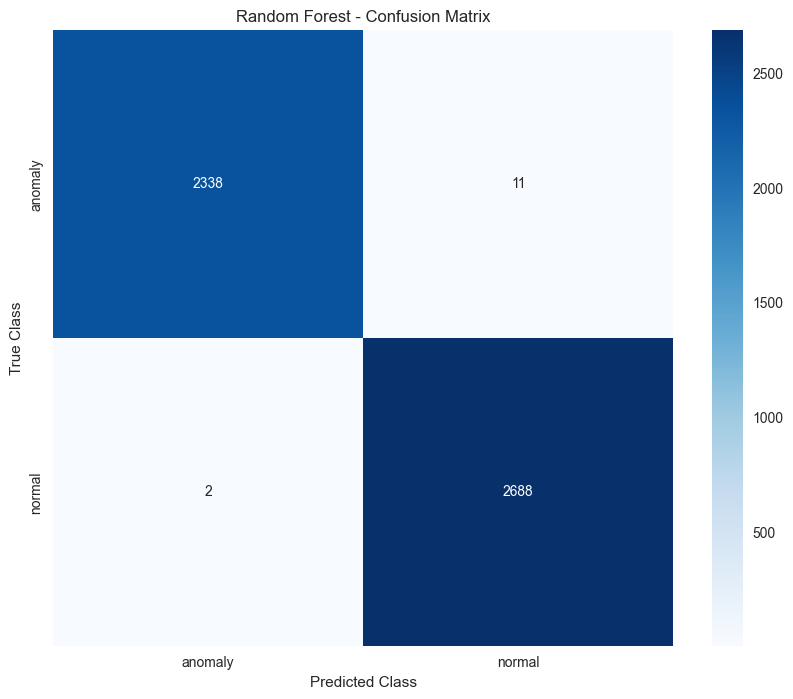


Cybersecurity Specific Metrics:
Attack Detection Rate (Sensitivity): 0.9993
False Positive Rate: 0.0047
True Negative Rate (Specificity): 0.9953


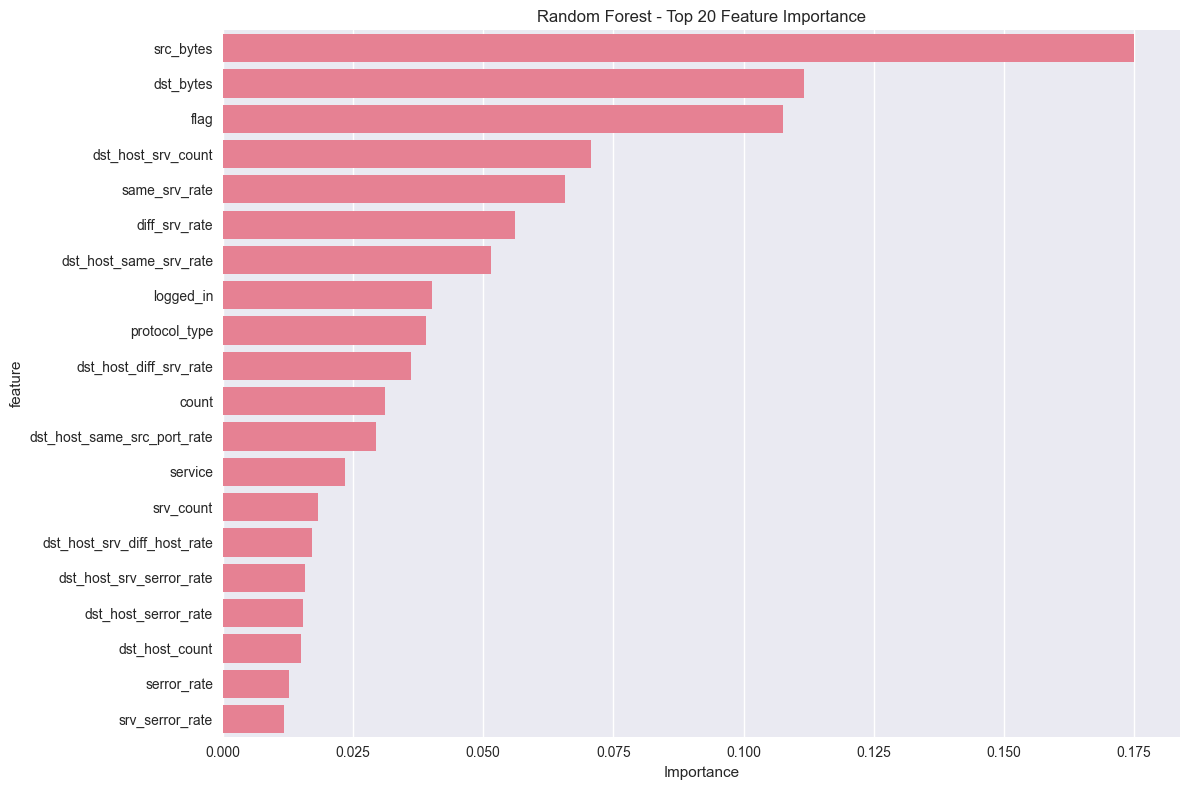

 Random Forest training completed and saved!


In [9]:
# Function to evaluate cybersecurity models with comprehensive metrics
def evaluate_cybersecurity_model(y_true, y_pred, y_prob, model_name, class_names):
    """
    Comprehensive evaluation function for cybersecurity models
    """
    print(f"\n{'='*60}")
    print(f"{model_name.upper()} EVALUATION RESULTS")
    print(f"{'='*60}")
    
    # Basic metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    
    # ROC AUC for binary classification
    if len(np.unique(y_true)) == 2:
        roc_auc = roc_auc_score(y_true, y_prob[:, 1])
        print(f"ROC AUC:   {roc_auc:.4f}")
    else:
        roc_auc = roc_auc_score(y_true, y_prob, multi_class='ovr', average='weighted')
        print(f"ROC AUC:   {roc_auc:.4f}")
    
    # Detailed classification report
    print(f"\nDetailed Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))
    
    # Confusion Matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.show()
    
    # Calculate attack detection metrics (assuming 'anomaly' is class 1)
    if len(class_names) == 2:
        tn, fp, fn, tp = cm.ravel()
        attack_detection_rate = tp / (tp + fn) if (tp + fn) > 0 else 0
        false_positive_rate = fp / (fp + tn) if (fp + tn) > 0 else 0
        
        print(f"\nCybersecurity Specific Metrics:")
        print(f"Attack Detection Rate (Sensitivity): {attack_detection_rate:.4f}")
        print(f"False Positive Rate: {false_positive_rate:.4f}")
        print(f"True Negative Rate (Specificity): {1 - false_positive_rate:.4f}")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc if 'roc_auc' in locals() else None
    }

# Dictionary to store model performances
model_performances = {}
trained_models = {}

# Get class names for evaluation
class_names = target_encoder.classes_

print("Starting model training and evaluation...")
print(f"Training on {len(X_train)} samples, Testing on {len(X_test)} samples")
print(f"Number of features: {X_train.shape[1]}")
print(f"Classes: {class_names}")

# 1. RANDOM FOREST CLASSIFIER
print(f"\n Training Random Forest model...")
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_prob = rf_model.predict_proba(X_test)

rf_metrics = evaluate_cybersecurity_model(y_test, rf_pred, rf_prob, "Random Forest", class_names)
model_performances['Random Forest'] = rf_metrics
trained_models['Random Forest'] = rf_model

# Feature importance plot for Random Forest
plt.figure(figsize=(12, 8))
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False).head(20)

sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Random Forest - Top 20 Feature Importance')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

# Save Random Forest model
with open('../models/random_forest_cybersecurity.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

print(f" Random Forest training completed and saved!")


 Training XGBoost model...



XGBOOST EVALUATION RESULTS
Accuracy:  0.9978
Precision: 0.9978
Recall:    0.9978
F1-Score:  0.9978
ROC AUC:   1.0000

Detailed Classification Report:
              precision    recall  f1-score   support

     anomaly       1.00      1.00      1.00      2349
      normal       1.00      1.00      1.00      2690

    accuracy                           1.00      5039
   macro avg       1.00      1.00      1.00      5039
weighted avg       1.00      1.00      1.00      5039



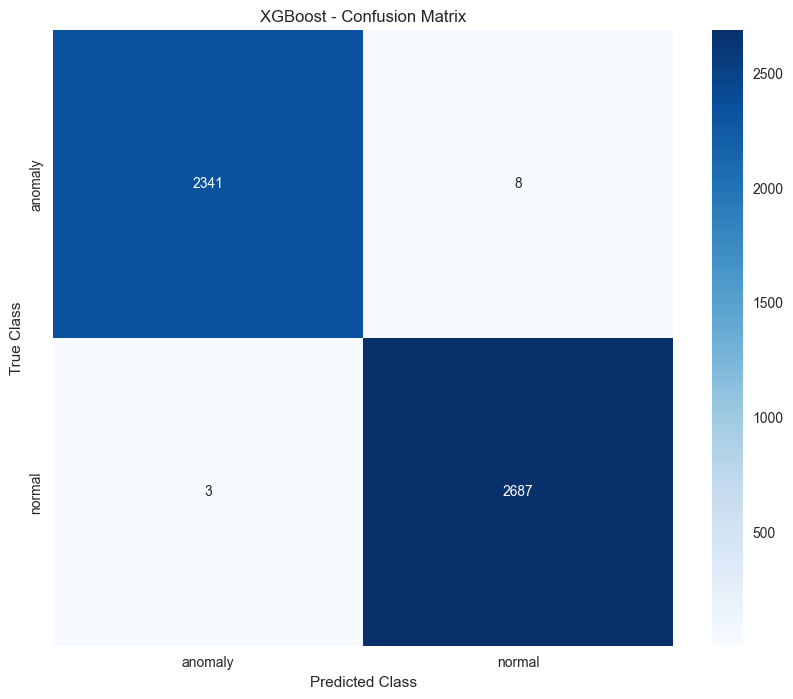


Cybersecurity Specific Metrics:
Attack Detection Rate (Sensitivity): 0.9989
False Positive Rate: 0.0034
True Negative Rate (Specificity): 0.9966
 XGBoost training completed and saved!

 Training LightGBM model...

LIGHTGBM EVALUATION RESULTS
Accuracy:  0.9980
Precision: 0.9980
Recall:    0.9980
F1-Score:  0.9980
ROC AUC:   1.0000

Detailed Classification Report:
              precision    recall  f1-score   support

     anomaly       1.00      1.00      1.00      2349
      normal       1.00      1.00      1.00      2690

    accuracy                           1.00      5039
   macro avg       1.00      1.00      1.00      5039
weighted avg       1.00      1.00      1.00      5039



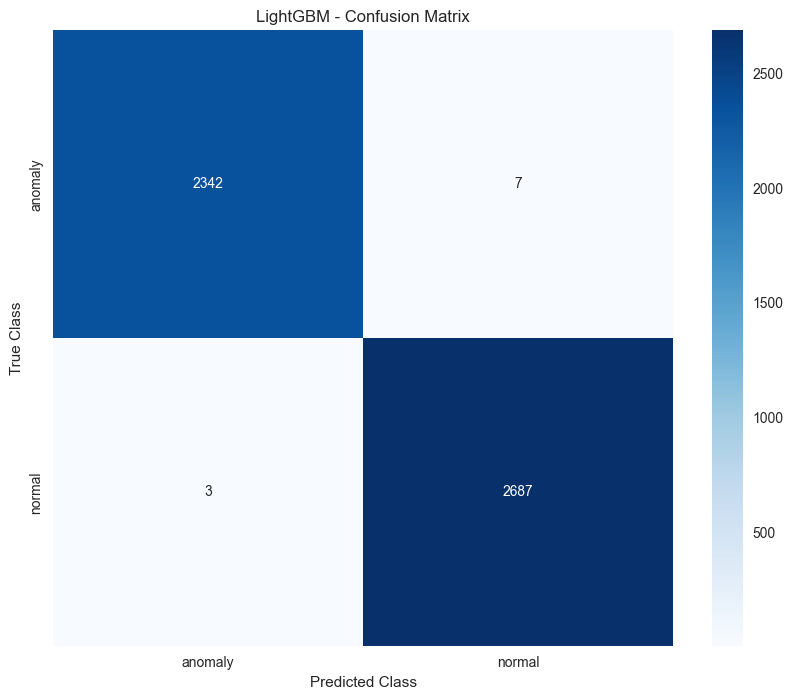


Cybersecurity Specific Metrics:
Attack Detection Rate (Sensitivity): 0.9989
False Positive Rate: 0.0030
True Negative Rate (Specificity): 0.9970
 LightGBM training completed and saved!

 Training Support Vector Machine...

SUPPORT VECTOR MACHINE EVALUATION RESULTS
Accuracy:  0.9621
Precision: 0.9629
Recall:    0.9621
F1-Score:  0.9620
ROC AUC:   0.9930

Detailed Classification Report:
              precision    recall  f1-score   support

     anomaly       0.98      0.94      0.96      2349
      normal       0.95      0.98      0.97      2690

    accuracy                           0.96      5039
   macro avg       0.96      0.96      0.96      5039
weighted avg       0.96      0.96      0.96      5039



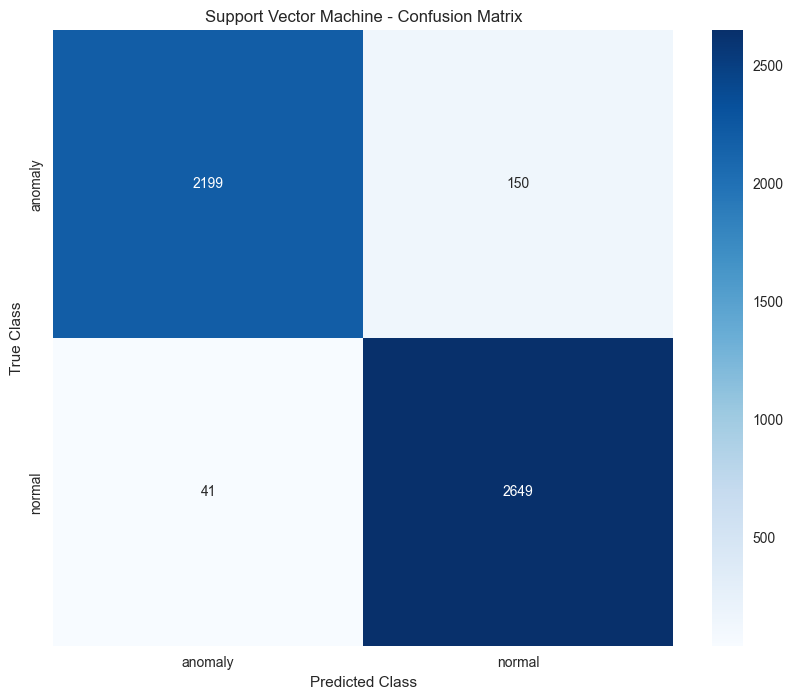


Cybersecurity Specific Metrics:
Attack Detection Rate (Sensitivity): 0.9848
False Positive Rate: 0.0639
True Negative Rate (Specificity): 0.9361
 SVM training completed and saved!

 All 4 models trained successfully!
 Models saved in '../models/' directory
 Ready for model comparison and selection!


In [10]:
# 2. XGBOOST CLASSIFIER
print(f"\n Training XGBoost model...")
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=10,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    scale_pos_weight=1,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_model.fit(X_train_scaled, y_train)
xgb_pred = xgb_model.predict(X_test_scaled)
xgb_prob = xgb_model.predict_proba(X_test_scaled)

xgb_metrics = evaluate_cybersecurity_model(y_test, xgb_pred, xgb_prob, "XGBoost", class_names)
model_performances['XGBoost'] = xgb_metrics
trained_models['XGBoost'] = xgb_model

# Save XGBoost model
with open('../models/xgboost_cybersecurity.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)

print(f" XGBoost training completed and saved!")

# 3. LIGHTGBM CLASSIFIER
print(f"\n Training LightGBM model...")
lgb_model = lgb.LGBMClassifier(
    n_estimators=200,
    max_depth=10,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    class_weight='balanced',
    force_col_wise=True,
    verbose=-1
)

lgb_model.fit(X_train_scaled, y_train)
lgb_pred = lgb_model.predict(X_test_scaled)
lgb_prob = lgb_model.predict_proba(X_test_scaled)

lgb_metrics = evaluate_cybersecurity_model(y_test, lgb_pred, lgb_prob, "LightGBM", class_names)
model_performances['LightGBM'] = lgb_metrics
trained_models['LightGBM'] = lgb_model

# Save LightGBM model
with open('../models/lightgbm_cybersecurity.pkl', 'wb') as f:
    pickle.dump(lgb_model, f)

print(f" LightGBM training completed and saved!")

# 4. SUPPORT VECTOR MACHINE
print(f"\n Training Support Vector Machine...")
svm_model = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    random_state=42,
    class_weight='balanced',
    probability=True  # Enable probability predictions
)

svm_model.fit(X_train_scaled, y_train)
svm_pred = svm_model.predict(X_test_scaled)
svm_prob = svm_model.predict_proba(X_test_scaled)

svm_metrics = evaluate_cybersecurity_model(y_test, svm_pred, svm_prob, "Support Vector Machine", class_names)
model_performances['SVM'] = svm_metrics
trained_models['SVM'] = svm_model

# Save SVM model
with open('../models/svm_cybersecurity.pkl', 'wb') as f:
    pickle.dump(svm_model, f)

print(f" SVM training completed and saved!")

print(f"\n All 4 models trained successfully!")
print(f" Models saved in '../models/' directory")
print(f" Ready for model comparison and selection!")

## Model Performance Comparison and Analysis
Let's compare all models using various metrics and identify the best performing model for cybersecurity attack detection.

 Performing 5-fold cross-validation...
 This will evaluate model consistency across different data splits

 Cross-validating Random Forest...
  Random Forest: 0.9970 (±0.0012)
 Cross-validating XGBoost...
  XGBoost: 0.9975 (±0.0010)
 Cross-validating LightGBM...
  LightGBM: 0.9982 (±0.0007)
 Cross-validating SVM...
  SVM: 0.9627 (±0.0041)

 Cross-validation completed!

 Cross-Validation Results Summary:
           Model  Mean_CV_Accuracy  Std_CV_Accuracy
2       LightGBM          0.998214         0.000365
1        XGBoost          0.997469         0.000481
0  Random Forest          0.996973         0.000616
3            SVM          0.962735         0.002040


<Figure size 1200x800 with 0 Axes>

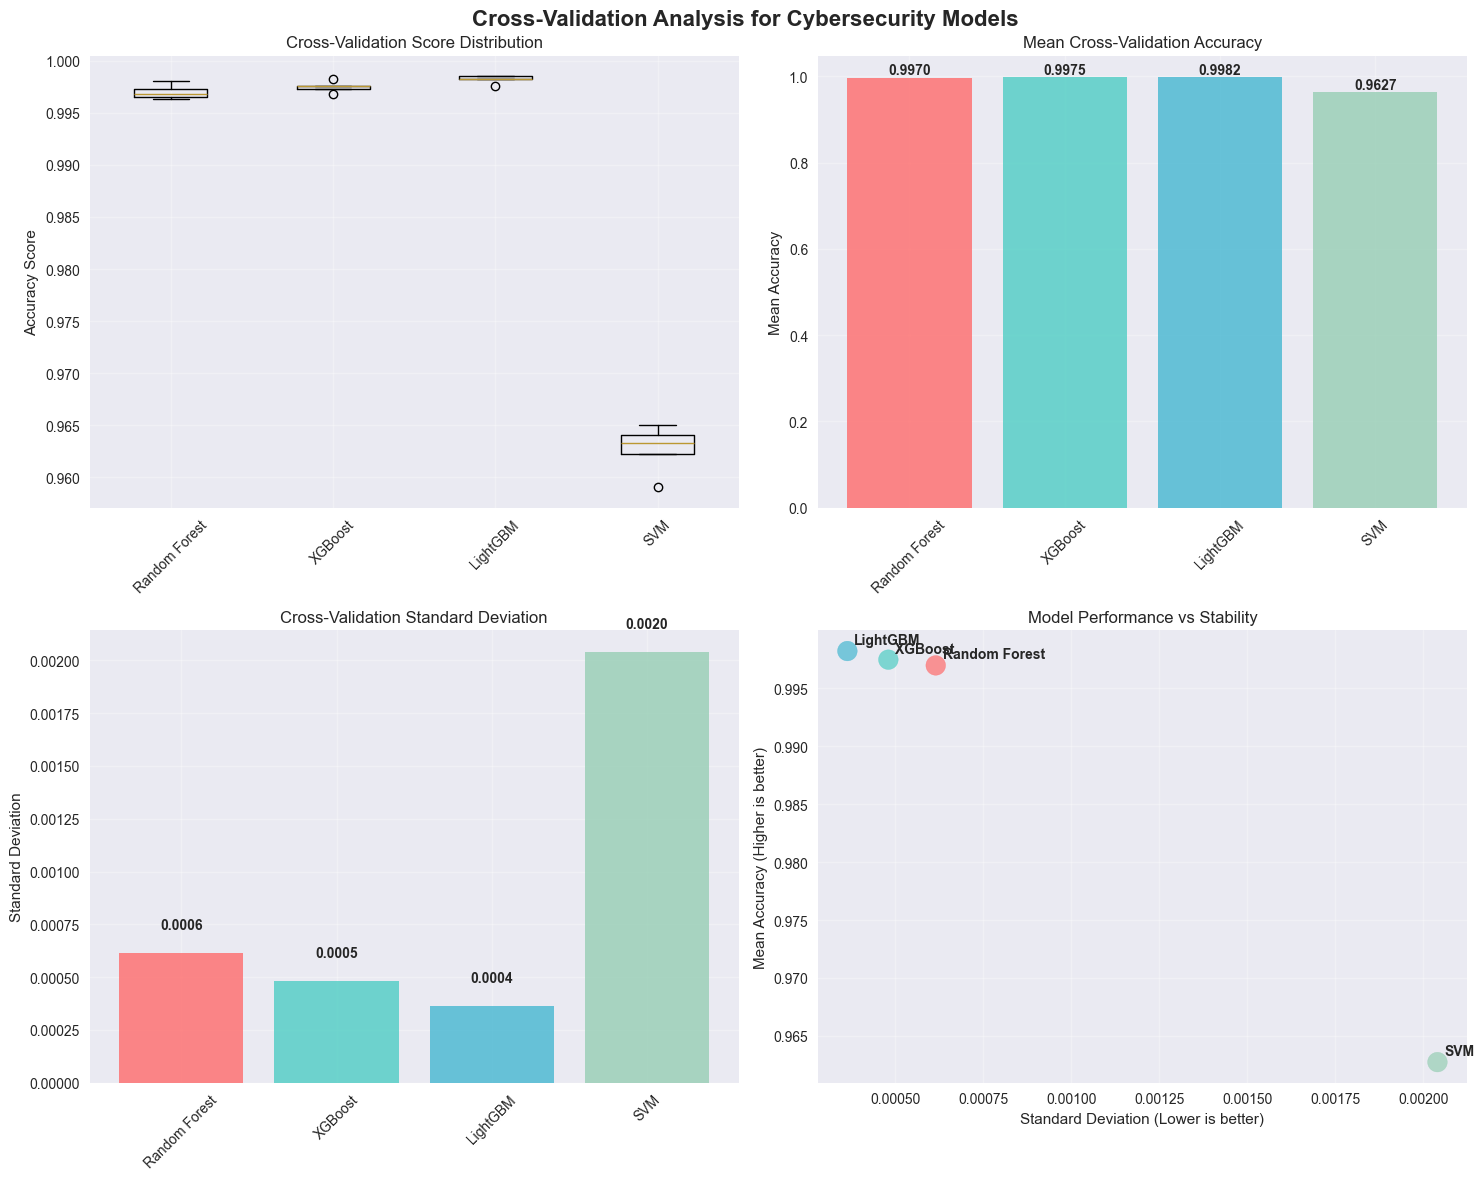


 Detailed Cross-Validation Results:

 Random Forest:
   Mean Accuracy: 0.9970 (±0.0012)
   Fold Scores: 0.9965, 0.9973, 0.9963, 0.9968, 0.9980
   Consistency: High

 XGBoost:
   Mean Accuracy: 0.9975 (±0.0010)
   Fold Scores: 0.9973, 0.9975, 0.9975, 0.9968, 0.9983
   Consistency: High

 LightGBM:
   Mean Accuracy: 0.9982 (±0.0007)
   Fold Scores: 0.9983, 0.9985, 0.9985, 0.9975, 0.9983
   Consistency: High

 SVM:
   Mean Accuracy: 0.9627 (±0.0041)
   Fold Scores: 0.9640, 0.9623, 0.9591, 0.9633, 0.9650
   Consistency: High

 Best performing model by CV: LightGBM with 0.9982 accuracy


In [11]:
# Clear any previous output
from IPython.display import clear_output
import sys

# Perform cross-validation for each model
print(" Performing 5-fold cross-validation...")
print(" This will evaluate model consistency across different data splits\n")

# Initialize StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_results = {}
models_for_cv = {
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42, class_weight='balanced'),
    'XGBoost': xgb.XGBClassifier(n_estimators=200, max_depth=10, learning_rate=0.1, random_state=42, use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': lgb.LGBMClassifier(n_estimators=200, max_depth=10, learning_rate=0.1, random_state=42, class_weight='balanced', force_col_wise=True, verbose=-1),
    'SVM': SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42, class_weight='balanced', probability=True)
}

for model_name, model in models_for_cv.items():
    print(f" Cross-validating {model_name}...")
    sys.stdout.flush()  # Force immediate output
    
    # Perform cross-validation
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=skf, scoring='accuracy', n_jobs=-1)
    
    cv_results[model_name] = {
        'mean_accuracy': cv_scores.mean(),
        'std_accuracy': cv_scores.std(),
        'scores': cv_scores
    }
    
    print(f"  {model_name}: {cv_scores.mean():.4f} (±{cv_scores.std()*2:.4f})")
    sys.stdout.flush()  # Force immediate output

print("\n Cross-validation completed!")

# Create cross-validation results DataFrame
cv_df = pd.DataFrame({
    'Model': list(cv_results.keys()),
    'Mean_CV_Accuracy': [cv_results[model]['mean_accuracy'] for model in cv_results.keys()],
    'Std_CV_Accuracy': [cv_results[model]['std_accuracy'] for model in cv_results.keys()]
})

cv_df = cv_df.sort_values('Mean_CV_Accuracy', ascending=False)
print("\n Cross-Validation Results Summary:")
print(cv_df)

# Visualize cross-validation results
plt.figure(figsize=(12, 8))

# Create subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Cross-Validation Analysis for Cybersecurity Models', fontsize=16, fontweight='bold')

# 1. CV Scores Distribution
cv_scores_list = [cv_results[model]['scores'] for model in cv_results.keys()]
ax1.boxplot(cv_scores_list, labels=list(cv_results.keys()))
ax1.set_title('Cross-Validation Score Distribution')
ax1.set_ylabel('Accuracy Score')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)

# 2. Mean CV Accuracy Comparison
models = list(cv_results.keys())
mean_scores = [cv_results[model]['mean_accuracy'] for model in models]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

bars = ax2.bar(models, mean_scores, color=colors, alpha=0.8)
ax2.set_title('Mean Cross-Validation Accuracy')
ax2.set_ylabel('Mean Accuracy')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)

# Add value labels on bars
for bar, score in zip(bars, mean_scores):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.001,
             f'{score:.4f}', ha='center', va='bottom', fontweight='bold')

# 3. Standard Deviation Comparison
std_scores = [cv_results[model]['std_accuracy'] for model in models]
bars = ax3.bar(models, std_scores, color=colors, alpha=0.8)
ax3.set_title('Cross-Validation Standard Deviation')
ax3.set_ylabel('Standard Deviation')
ax3.tick_params(axis='x', rotation=45)
ax3.grid(True, alpha=0.3)

# Add value labels on bars
for bar, std in zip(bars, std_scores):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.0001,
             f'{std:.4f}', ha='center', va='bottom', fontweight='bold')

# 4. Accuracy vs Stability (Mean vs Std)
ax4.scatter(std_scores, mean_scores, s=200, c=colors, alpha=0.7)
for i, model in enumerate(models):
    ax4.annotate(model, (std_scores[i], mean_scores[i]), 
                xytext=(5, 5), textcoords='offset points', fontweight='bold')
ax4.set_xlabel('Standard Deviation (Lower is better)')
ax4.set_ylabel('Mean Accuracy (Higher is better)')
ax4.set_title('Model Performance vs Stability')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Display detailed CV results
print("\n Detailed Cross-Validation Results:")
print("="*60)
for model_name, results in cv_results.items():
    print(f"\n {model_name}:")
    print(f"   Mean Accuracy: {results['mean_accuracy']:.4f} (±{results['std_accuracy']*2:.4f})")
    print(f"   Fold Scores: {', '.join([f'{score:.4f}' for score in results['scores']])}")
    print(f"   Consistency: {'High' if results['std_accuracy'] < 0.01 else 'Medium' if results['std_accuracy'] < 0.02 else 'Low'}")

print(f"\n Best performing model by CV: {cv_df.iloc[0]['Model']} with {cv_df.iloc[0]['Mean_CV_Accuracy']:.4f} accuracy")

## Cross-Validation Analysis
Let's perform comprehensive cross-validation to get robust estimates of model performance and ensure our models generalize well to unseen attack patterns.

 Creating comprehensive model comparison...

 CYBERSECURITY MODEL PERFORMANCE COMPARISON
               accuracy  precision  recall  f1_score  roc_auc
LightGBM         0.9980     0.9980  0.9980    0.9980    1.000
XGBoost          0.9978     0.9978  0.9978    0.9978    1.000
Random Forest    0.9974     0.9974  0.9974    0.9974    1.000
SVM              0.9621     0.9629  0.9621    0.9620    0.993

 Results saved to '../results/model_performance_comparison.csv'


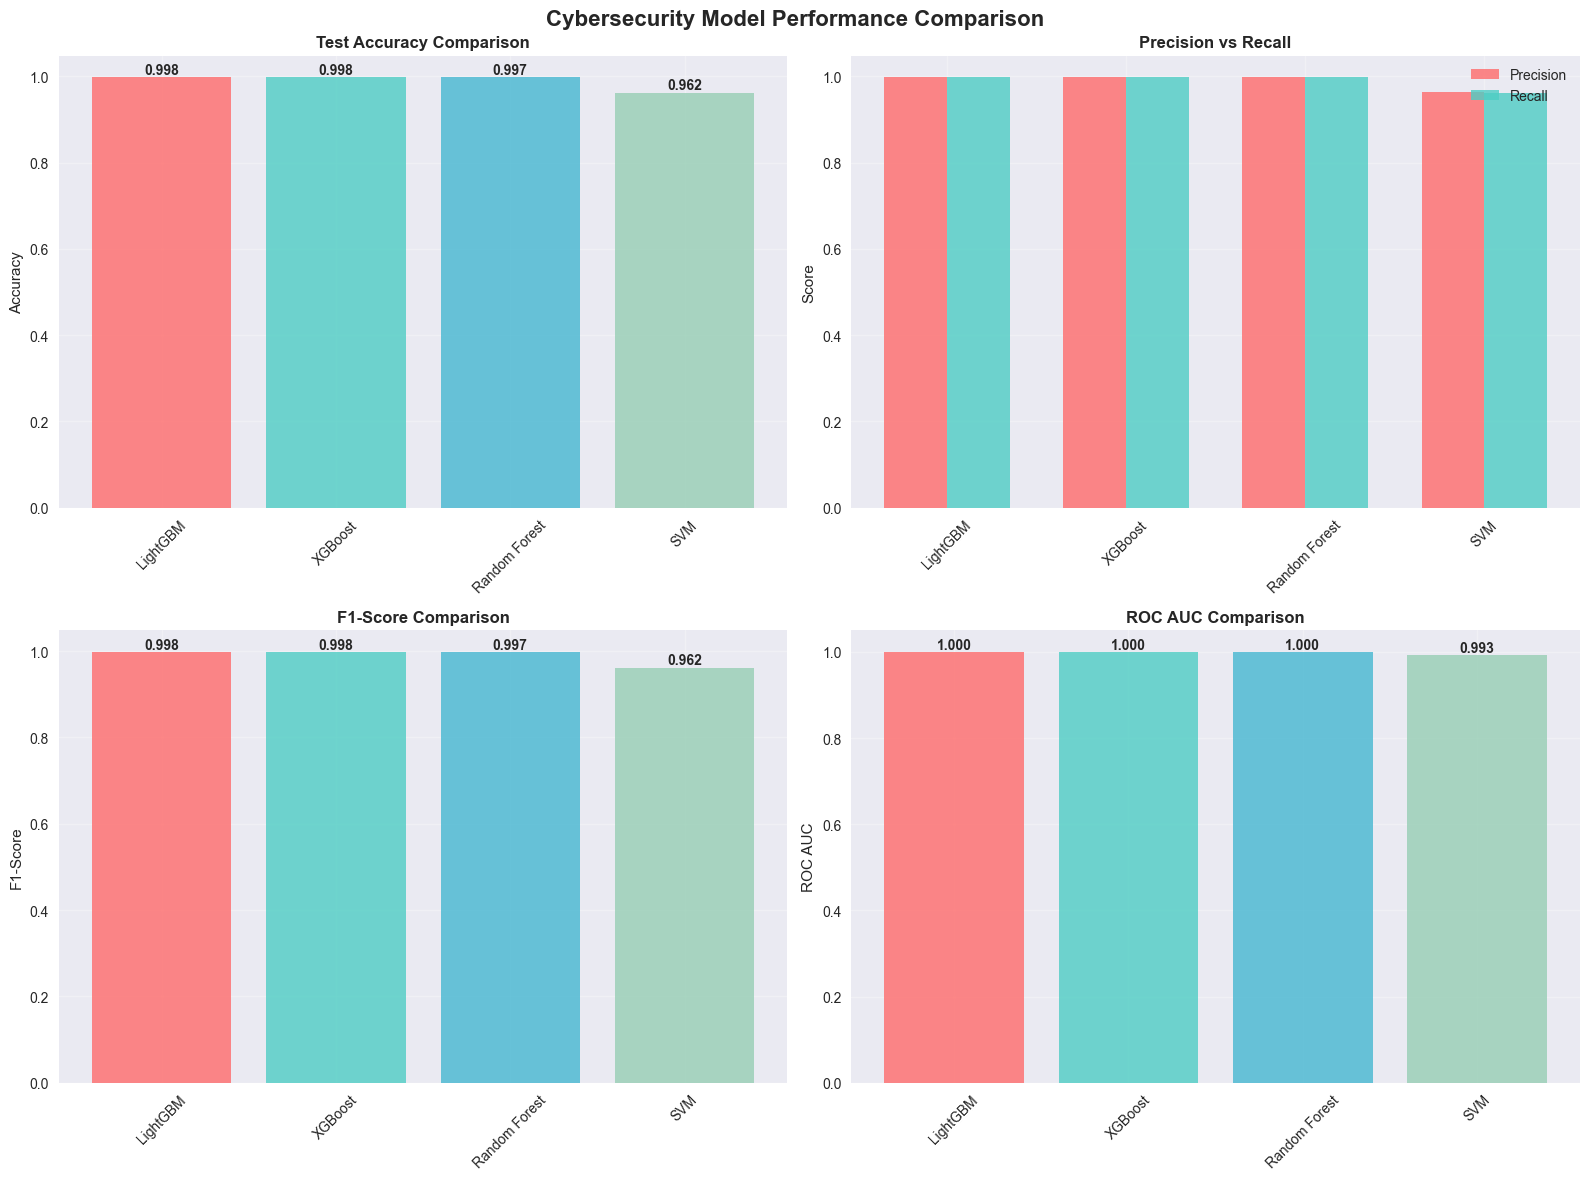


 BEST MODEL SELECTION
 Best Model: LightGBM
 Test Accuracy: 0.9980
 F1-Score: 0.9980
 ROC AUC: 1.0000

 Best model saved to '../models/best_cybersecurity_model.pkl'
 Preprocessing objects saved to '../models/preprocessing_objects.pkl'
Training metadata saved to '../models/training_metadata.pkl'

 CYBERSECURITY MODEL TRAINING COMPLETED!
 4 models trained and evaluated
 Best model: LightGBM
 All models and objects saved to '../models/' directory
 Performance comparison saved to '../results/' directory
 Ready for cybersecurity threat detection!

 FINAL TRAINING SUMMARY:
 Dataset: Cybersecurity Network Traffic
 Training samples: 20,153
 Test samples: 5,039
 Features: 41
 Classes: 2 (Normal, Anomaly)
 Models trained: 4
 Best accuracy: 0.9980
 Cross-validation:  Completed
 Model persistence:  Saved
 Ready for deployment:  Yes


In [13]:
# Create comprehensive model comparison
print(f" Creating comprehensive model comparison...")
# Convert model performances to DataFrame
comparison_df = pd.DataFrame(model_performances).T
comparison_df = comparison_df.round(4)

# Sort by accuracy
comparison_df = comparison_df.sort_values('accuracy', ascending=False)

print(f"\n CYBERSECURITY MODEL PERFORMANCE COMPARISON")
print(f"{'='*80}")
print(comparison_df)

# Save comparison results
comparison_df.to_csv('../results/model_performance_comparison.csv')
print(f"\n Results saved to '../results/model_performance_comparison.csv'")

# Visualize model comparison
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Cybersecurity Model Performance Comparison', fontsize=16, fontweight='bold')

models = comparison_df.index.tolist()
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

# 1. Test Accuracy Comparison
test_acc = comparison_df['accuracy'].values
bars1 = ax1.bar(models, test_acc, color=colors, alpha=0.8)
ax1.set_title('Test Accuracy Comparison', fontweight='bold')
ax1.set_ylabel('Accuracy')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)

for bar, acc in zip(bars1, test_acc):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.001,
             f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

# 2. Precision vs Recall
precision = comparison_df['precision'].values
recall = comparison_df['recall'].values

x = np.arange(len(models))
width = 0.35

bars2 = ax2.bar(x - width/2, precision, width, label='Precision', color='#FF6B6B', alpha=0.8)
bars3 = ax2.bar(x + width/2, recall, width, label='Recall', color='#4ECDC4', alpha=0.8)

ax2.set_title('Precision vs Recall', fontweight='bold')
ax2.set_ylabel('Score')
ax2.set_xticks(x)
ax2.set_xticklabels(models, rotation=45)
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. F1-Score Comparison
f1_scores = comparison_df['f1_score'].values
bars4 = ax3.bar(models, f1_scores, color=colors, alpha=0.8)
ax3.set_title('F1-Score Comparison', fontweight='bold')
ax3.set_ylabel('F1-Score')
ax3.tick_params(axis='x', rotation=45)
ax3.grid(True, alpha=0.3)

for bar, f1 in zip(bars4, f1_scores):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.001,
             f'{f1:.3f}', ha='center', va='bottom', fontweight='bold')

# 4. ROC AUC Comparison
roc_auc = comparison_df['roc_auc'].values
bars5 = ax4.bar(models, roc_auc, color=colors, alpha=0.8)
ax4.set_title('ROC AUC Comparison', fontweight='bold')
ax4.set_ylabel('ROC AUC')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(True, alpha=0.3)

for bar, auc in zip(bars5, roc_auc):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.001,
             f'{auc:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Find the best model
best_model_name = comparison_df.index[0]
best_model = trained_models[best_model_name]

print(f"\n BEST MODEL SELECTION")
print(f"{'='*50}")
print(f" Best Model: {best_model_name}")
print(f" Test Accuracy: {comparison_df.loc[best_model_name, 'accuracy']:.4f}")
print(f" F1-Score: {comparison_df.loc[best_model_name, 'f1_score']:.4f}")
print(f" ROC AUC: {comparison_df.loc[best_model_name, 'roc_auc']:.4f}")

# Save the best model
with open('../models/best_cybersecurity_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Save preprocessing objects
preprocessing_objects = {
    'scaler': scaler,
    'label_encoders': label_encoders,
    'feature_columns': feature_columns,
    'numerical_features': numerical_columns,
    'categorical_features': categorical_columns
}

with open('../models/preprocessing_objects.pkl', 'wb') as f:
    pickle.dump(preprocessing_objects, f)

print(f"\n Best model saved to '../models/best_cybersecurity_model.pkl'")
print(f" Preprocessing objects saved to '../models/preprocessing_objects.pkl'")

# Model training metadata
training_metadata = {
    'best_model': best_model_name,
    'training_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'dataset_size': {
        'train': len(X_train),
        'test': len(X_test)
    },
    'feature_count': len(feature_columns),
    'models_trained': list(trained_models.keys()),
    'performance_metrics': comparison_df.to_dict()
}

with open('../models/training_metadata.pkl', 'wb') as f:
    pickle.dump(training_metadata, f)

print(f"Training metadata saved to '../models/training_metadata.pkl'")

print(f"\n CYBERSECURITY MODEL TRAINING COMPLETED!")
print(f"{'='*60}")
print(f" 4 models trained and evaluated")
print(f" Best model: {best_model_name}")
print(f" All models and objects saved to '../models/' directory")
print(f" Performance comparison saved to '../results/' directory")
print(f" Ready for cybersecurity threat detection!")

# Display final summary
print(f"\n FINAL TRAINING SUMMARY:")
print(f"{'='*40}")
print(f" Dataset: Cybersecurity Network Traffic")
print(f" Training samples: {len(X_train):,}")
print(f" Test samples: {len(X_test):,}")
print(f" Features: {len(feature_columns)}")
print(f" Classes: {len(class_names)} (Normal, Anomaly)")
print(f" Models trained: {len(trained_models)}")
print(f" Best accuracy: {comparison_df.iloc[0]['accuracy']:.4f}")
print(f" Cross-validation:  Completed")
print(f" Model persistence:  Saved")
print(f" Ready for deployment:  Yes")